![](fig/univ.png)

# AI-2: Convolutional Neural Network
## Homework 1: Artificial Neural Networks, Model Interpretation, and Regularization

**AI2 Cohort 2**<br/>
**Univ.AI**<br/>
**Instructor**: Ignacio Becker<br />
**Maximum Score**: 100 <br/>
**HW PARTNER Names** : Adarsh Roy, Abhineet Sharma
<hr style="height:2.4pt">

In [ ]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML

In [ ]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
%matplotlib inline

### INSTRUCTIONS


- This homework is a jupyter notebook. Download and work on it on your local machine.

- This homework should be submitted in pairs.

- Ensure you and your partner together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code. 

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropraite plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

### Names of the people who worked on this homework together
#### /name here/

<a id="contents"></a>

## Notebook Contents

- [**PART 1 [40 pts]: Model interpretation and predictive intervals in NN**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2.1 [30 pts]: Kannada MNIST Kaggle competition using ANNs**](#part2.1)
  - [Problem Statement](#part2.1intro)
  - [The Kannada MNIST Dataset](#part2.1about)
  - [Downloading the Data Files](#part2.1data)
  - [AI2-C2 Homework Kaggle Competition](#part2.1kaggle)
  - [Questions](#part2.1questions)
  - [Solutions](#part2.1solutions)

- [**PART 2.2 [30 pts]: Kannada MNIST using CNNs**](#part2)
  - [Questions](#part2.2questions)
  - [Solutions](#part2.2solutions)


---

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
<h1> PART 1 [40 pts]: Model interpretation and predictive intervals in NN </h1> 

<a id="part1intro"></a>

<b> Overview and Data Description </b>

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival based on features that could be measured as the flight takes off.  
We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.  

The included variables are:

**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of that airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** The observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

</div> 

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h2>PART 1: Questions</h2> 

**1.1.1 [2 points]**  Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater than or equal to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 

**1.1.2 [2 points]** Preprocess the data: one-hot-encode the non-numeric categorical variables, deal with missing values if there are any, scale your data, and split the data into training and test sets (use an 80/20 split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.

**1.2 [2 points]** Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use appropriate activation functions for each layer, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for an appropriate number of epochs based on the results of your training and validation accuracy plot, and feel free to use the default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

**1.3 [10 points]** To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` training predictions.

- **1.3.1** For this we need to modify our training set. First, generate a set of `NN_model` class predictions for the training set. These training predictions will be used to form a revised training dataset for our proxy model: (a) use all of the same $X$ values used by `NN_model` for our $X$ train and (b) replace the actual response values $y$ with the predicted $\hat{y}$ values generated by the fitted `NN_model`.

- **1.3.2** Next, fit a logistic regression model using your revised training dataset from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.

- **1.3.3** Now use sklearn's `permutation_importance` class (already included in this notebook's imports) to compute the feature importance using the `logreg` model.

  - Read the official documentation for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature.) as well as [here](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) to learn how it works.

  - You can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

  - Measure the **relative** variable importance (i.e. as a proportion of the variable importance of the most important variable identified by `permutation_importance`) and generate a barplot illustrating the relative variable importances for the top-10 most important predictors identified using `permutation_importance`.

**1.4 [10 points]** Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. 

   - **1.4.1** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.
   - **1.4.2** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).

   - **1.4.3**   Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.


   - **1.4.4** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 
  - **1.4.5** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.
  
**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your datapoints based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.
    
**1.5 [2 points]**
    
In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% CI bounds clearly marked and reported in each subplot and the actual class of each observation included in each subplot's title for easy reference.

Interpret what you see in 3-5 sentences.

    
**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the provided `progressbar` function below to visually track the progress of your bootstraps.
    
**1.6 [12 points]**
    
Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

    
**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 

</div>

<a id="part1solutions"></a>

## PART 1: Solutions


<div class='exercise-r'>  

**1.1**

</div>

Uploading The Flights.CSV File

In [ ]:
# your code here 
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['flights.csv']))


Saving flights.csv to flights (1).csv


In [ ]:
df.head()

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,23.0,2586,342.0,9,7,15,240,3,SFO,JFK
1,10.0,1235,185.0,5,6,11,366,4,LAX,DFW
2,-7.0,184,76.0,4,17,18,172,7,BOS,LGA
3,68.0,862,148.0,7,19,21,260,7,IAH,DEN
4,24.0,236,71.0,3,20,21,266,2,LAS,LAX


In [ ]:
df['DELAY_OR_NOT']=df['ARRIVAL_DELAY']>=15

In [ ]:
df.head()

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
0,23.0,2586,342.0,9,7,15,240,3,SFO,JFK,True
1,10.0,1235,185.0,5,6,11,366,4,LAX,DFW,False
2,-7.0,184,76.0,4,17,18,172,7,BOS,LGA,False
3,68.0,862,148.0,7,19,21,260,7,IAH,DEN,True
4,24.0,236,71.0,3,20,21,266,2,LAS,LAX,True


In [ ]:
df['DELAY_OR_NOT']=df['DELAY_OR_NOT'].map({True:1,False:0})

In [ ]:
df

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
0,23.0,2586,342.0,9,7,15,240,3,SFO,JFK,1
1,10.0,1235,185.0,5,6,11,366,4,LAX,DFW,0
2,-7.0,184,76.0,4,17,18,172,7,BOS,LGA,0
3,68.0,862,148.0,7,19,21,260,7,IAH,DEN,1
4,24.0,236,71.0,3,20,21,266,2,LAS,LAX,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,77.0,946,179.0,6,17,20,172,4,BOS,ATL,1
9996,-5.0,391,90.0,10,6,7,26,2,11292,14869,0
9997,38.0,236,73.0,11,20,21,266,5,LAS,LAX,1
9998,-9.0,317,80.0,8,17,19,13,3,MYR,ATL,0


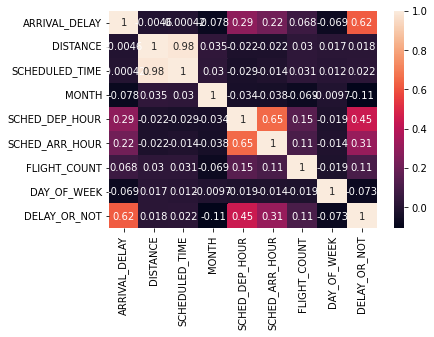

In [ ]:
sns.heatmap(data=df.corr(),annot=True)

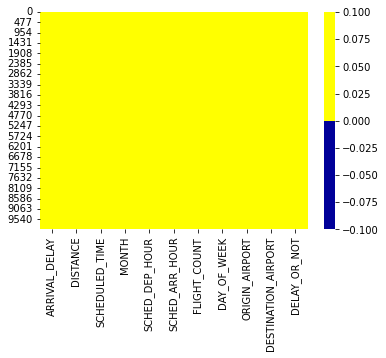

In [ ]:
cols=df.columns[:11]
colors=["#000099","#ffff00"]
sns.heatmap(df[cols].isnull(),cmap=sns.color_palette(colors))

In [ ]:
'''
Selected_cols=['ARRIVAL_DELAY','DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT','DAY_OF_WEEK']
check=df[Selected_cols]
one_hot_df_1 = pd.get_dummies(df[['DELAY_OR_NOT']])
one_hot_df_2 = pd.get_dummies(df[['ORIGIN_AIRPORT']])
one_hot_df_3 = pd.get_dummies(df[['DESTINATION_AIRPORT']])
df2=pd.concat([check,one_hot_df_1,one_hot_df_2,one_hot_df_3],axis=1)
df2
'''
df.dtypes
df_ORIGIN_AIRPORT  = df['ORIGIN_AIRPORT']
df_DESTINATION_AIRPORT  = df['DESTINATION_AIRPORT']
df['DELAY_OR_NOT'] = df['DELAY_OR_NOT'].astype(int)
df.head()

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
0,23.0,2586,342.0,9,7,15,240,3,SFO,JFK,1
1,10.0,1235,185.0,5,6,11,366,4,LAX,DFW,0
2,-7.0,184,76.0,4,17,18,172,7,BOS,LGA,0
3,68.0,862,148.0,7,19,21,260,7,IAH,DEN,1
4,24.0,236,71.0,3,20,21,266,2,LAS,LAX,1


In [ ]:
df2 = df.drop(['ORIGIN_AIRPORT','DESTINATION_AIRPORT','ARRIVAL_DELAY'],axis=1)
df2.head()

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,DELAY_OR_NOT
0,2586,342.0,9,7,15,240,3,1
1,1235,185.0,5,6,11,366,4,0
2,184,76.0,4,17,18,172,7,0
3,862,148.0,7,19,21,260,7,1
4,236,71.0,3,20,21,266,2,1


**1.1.2**

In [ ]:
scaler = StandardScaler()
dfscaled = scaler.fit_transform(df[['DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT','DAY_OF_WEEK']])
dfscaled = pd.DataFrame(dfscaled,columns =['DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT','DAY_OF_WEEK'])

In [ ]:
frames = [df_ORIGIN_AIRPORT, df_DESTINATION_AIRPORT,dfscaled]
end = pd.concat(frames,axis=1)
end['DELAY_OR_NOT'] = df.ARRIVAL_DELAY >=15
end['DELAY_OR_NOT'] = end['DELAY_OR_NOT'].astype(int)

result1 = pd.get_dummies(end,columns=["ORIGIN_AIRPORT"],prefix="origin")
result = pd.get_dummies(result1,columns=["DESTINATION_AIRPORT"],prefix="dest")
result.head()

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,...,dest_SAV,dest_SBA,dest_SBN,dest_SBP,dest_SCE,dest_SDF,dest_SEA,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM
0,2.908410,2.658125,0.808805,-1.448739,-0.090169,0.209781,-0.438462,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.670670,0.564125,-0.386503,-1.653998,-0.845350,0.908627,0.070077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.070163,-0.889671,-0.685330,0.603852,0.476217,-0.167374,1.595691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.052848,0.070634,0.211151,1.014370,1.042603,0.320709,1.595691,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.984033,-0.956359,-0.984157,1.219629,1.042603,0.353988,-0.947000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Not To be Confused with rest of the code
'''
frames = [df_ORIGIN_AIRPORT,df_DESTINATION_AIRPORT,dfscaled]
result = pd.concat(frames,axis=1)
result['DELAY_OR_NOT'] = df.ARRIVAL_DELAY >=15
result['DELAY_OR_NOT'] = result['DELAY_OR_NOT'].astype(int)
'''

"\nframes = [df_ORIGIN_AIRPORT,df_DESTINATION_AIRPORT,dfscaled]\nresult = pd.concat(frames,axis=1)\nresult['DELAY_OR_NOT'] = df.ARRIVAL_DELAY >=15\nresult['DELAY_OR_NOT'] = result['DELAY_OR_NOT'].astype(int)\n"

In [ ]:
X = result.drop(["DELAY_OR_NOT"],axis = 1).values
y = result['DELAY_OR_NOT'].values

In [ ]:
result.head()

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,...,dest_SAV,dest_SBA,dest_SBN,dest_SBP,dest_SCE,dest_SDF,dest_SEA,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM
0,2.908410,2.658125,0.808805,-1.448739,-0.090169,0.209781,-0.438462,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.670670,0.564125,-0.386503,-1.653998,-0.845350,0.908627,0.070077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.070163,-0.889671,-0.685330,0.603852,0.476217,-0.167374,1.595691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.052848,0.070634,0.211151,1.014370,1.042603,0.320709,1.595691,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.984033,-0.956359,-0.984157,1.219629,1.042603,0.353988,-0.947000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
X

array([[ 2.90841033,  2.65812507,  0.80880501, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67066961,  0.56412496, -0.38650277, ...,  0.        ,
         0.        ,  0.        ],
       [-1.07016347, -0.88967129, -0.68532971, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.98403281, -0.92968403,  1.4064589 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.84986775, -0.83632097,  0.50997806, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.50425878,  2.2313225 ,  1.10763195, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
len(X[0])

810

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=111)

**1.2**

In [ ]:
NN_model = models.Sequential(name='Unregularized')

# Add 2 hidden layers with 15 neurons each
NN_model.add(layers.Input(shape = len(X[0]), name = 'input'))
NN_model.add(layers.Dense(15,  activation='relu'))
NN_model.add(layers.Dense(15,  activation='relu'))
NN_model.add(layers.Dense(1,  activation='sigmoid'))
#Model Summary
NN_model.summary()

Model: "Unregularized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_465 (Dense)           (None, 15)                12165     
                                                                 
 dense_466 (Dense)           (None, 15)                240       
                                                                 
 dense_467 (Dense)           (None, 1)                 16        
                                                                 
Total params: 12,421
Trainable params: 12,421
Non-trainable params: 0
_________________________________________________________________


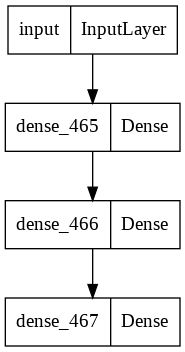

In [ ]:
tf.keras.utils.plot_model(NN_model)

In [ ]:
NN_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = NN_model.fit(x_train,y_train,validation_split=0.2,epochs=100,batch_size=10,verbose=1)


Text(0.5, 0.98, 'ANN Training')

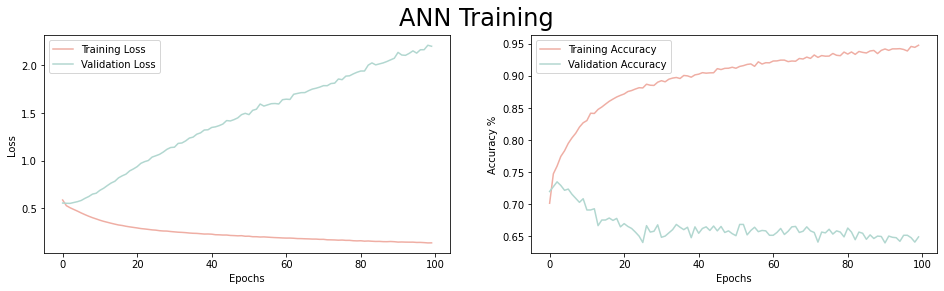

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('ANN Training', fontsize = 24)

In [ ]:
train_accuracy = NN_model.evaluate(x_train,y_train)[1]
test_accuracy = NN_model.evaluate(x_test,y_test)[1]
print(f'The training set accuracy for the model is {train_accuracy}\
    \n The test set accuracy for the model is {test_accuracy}')

63/63 [==============================] - 0s 2ms/step - loss: 2.3740 - accuracy: 0.6425
The training set accuracy for the model is 0.893875002861023    
 The test set accuracy for the model is 0.6424999833106995


In [ ]:
# Use the model above to predict on the test data
y_pred_test = NN_model.predict(x_test)

In [ ]:
y_pred_test

array([[9.7359014e-01],
       [1.8048286e-04],
       [9.9999464e-01],
       ...,
       [9.9216694e-01],
       [1.0000000e+00],
       [9.9941254e-01]], dtype=float32)

In [ ]:
y_pred = (NN_model.predict(x_train)> 0.5).astype('int32')
y_hat = pd.DataFrame(data = y_pred)

In [ ]:
y_test_pred = (NN_model.predict(x_test)> 0.5).astype('int32')


In [ ]:
# your code here
train = accuracy_score(y_train,y_pred)
test = accuracy_score(y_test,y_test_pred)
print("The Train Accuracy is : ",train)
print("The Test Accuracy is : ",test)

The Train Accuracy is :  0.893875
The Test Accuracy is :  0.6425


In [ ]:
 print("NN_model_train_auc:", roc_auc_score(y_train, y_pred))

NN_model_train_auc: 0.8936811900913731


In [ ]:
y_hat.columns = ["output"]
y_log_train = y_hat["output"].values
y_log_train

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

<div class='exercise-r'>

**1.3**

</div>

In [ ]:
# Fit the logistic regression model
# your code here
validation_accuracy = []
Clist = [0.01,0.1,1,100,1000,10000]
for i in Clist:

    # For each i in Clist, make a logistic regression model, with max_iter = 16000
    logreg = LogisticRegression(C=i, max_iter=1600)

    # Fit the model on the training data

    logreg.fit(x_train, y_log_train)

    y_train_pred=logreg.predict(x_train)
    # Predict the model on the validation data
    y_val_pred = logreg.predict(x_test)

    # Append the validation accuracy using the accuracy_score function
    validation_accuracy.append(accuracy_score(y_test, y_val_pred))

print("Accuracy=",validation_accuracy)


Accuracy= [0.7195, 0.7285, 0.7165, 0.7005, 0.6985, 0.698]


In [ ]:
from sklearn.metrics import r2_score
print("The R2 Score of the Model is :",r2_score(y_log_train,y_train_pred))


The R2 Score of the Model is : 0.15452628647521915


In [ ]:
r = permutation_importance(logreg, x_test, y_test, scoring='accuracy')

In [ ]:
# get importance
importance = r.importances_mean
list_r=[]
for i in range(len(importance)):
  list_r.append([result.columns[i],importance[i]])
list_r

In [ ]:
#Sorting the LIST
list_r_2=sorted(list_r,key=lambda x:x[1],reverse=True)

In [ ]:
# Extracting the top 10 features
list_r_2[0:10]

[['SCHED_DEP_HOUR', 0.15149999999999994],
 ['FLIGHT_COUNT', 0.09159999999999993],
 ['SCHEDULED_TIME', 0.07659999999999996],
 ['DISTANCE', 0.06929999999999994],
 ['origin_ASE', 0.02289999999999992],
 ['dest_LAW', 0.011799999999999922],
 ['dest_ONT', 0.009999999999999964],
 ['origin_ONT', 0.009799999999999965],
 ['origin_DEN', 0.006999999999999962],
 ['dest_JAX', 0.0064999999999999945]]

**Note** : While Running the Aforementioned code using the permutation_importance code, few of the important features(mainly the categorical ones) changed [Randomness]

In [ ]:
''' OLD ONES : [For Reference]
[['SCHED_DEP_HOUR', 0.14979999999999996],
 ['FLIGHT_COUNT', 0.07339999999999995],
 ['SCHEDULED_TIME', 0.06959999999999995],
 ['DISTANCE', 0.06839999999999995],
 ['origin_ASE', 0.02009999999999996],
 ['dest_LAW', 0.008599999999999941],
 ['origin_ONT', 0.007999999999999941],
 ['origin_DEN', 0.006699999999999928],
 ['dest_ONT', 0.006599999999999939],
 ['dest_LFT', 0.005199999999999938]]
 '''

In [ ]:
#Accessing just one value for Debugging purpose:
list_r_2[2][1]

0.07659999999999996

In [ ]:
list_r_2_val=[]
list_r_2_col=[]
for i in range(10):
  list_r_2_val.append(list_r_2[i][1])
  list_r_2_col.append(list_r_2[i][0])

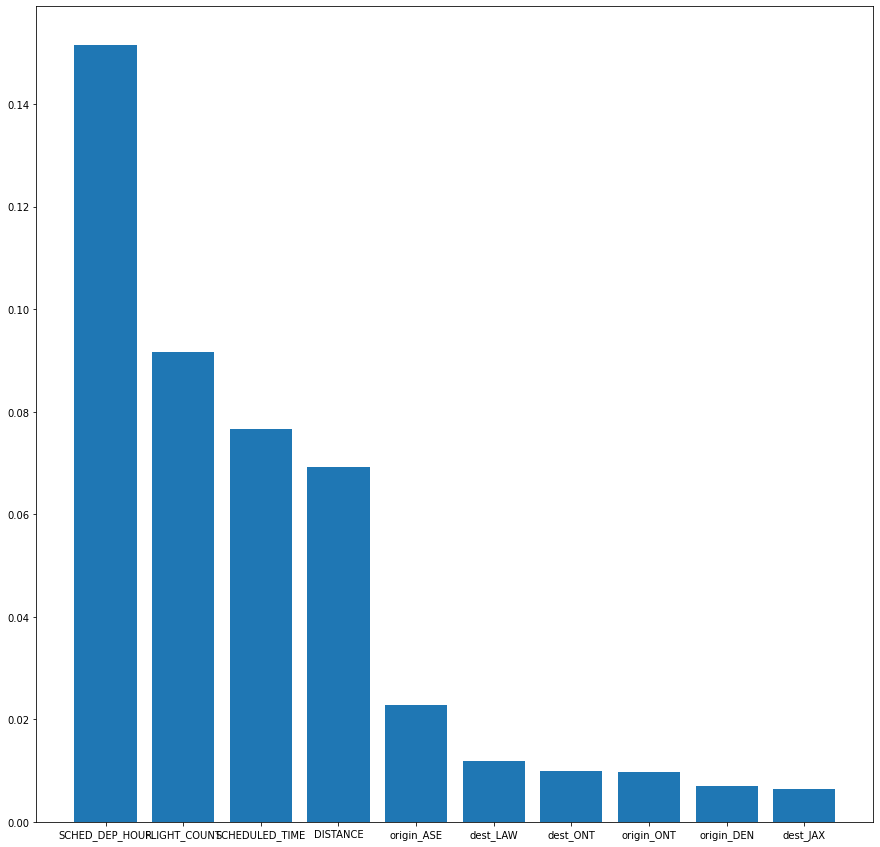

In [ ]:
plt.figure(figsize=(15, 15))
plt.bar(x=list_r_2_col,height=list_r_2_val)
plt.show()

**1.4 [10 Points]**

In [ ]:
one_hot_encoded = result.drop(columns=['DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT','DAY_OF_WEEK'])
not_scaled= df[['DISTANCE','SCHEDULED_TIME','MONTH','SCHED_DEP_HOUR','SCHED_ARR_HOUR','FLIGHT_COUNT','DAY_OF_WEEK']]
final_result=pd.concat([one_hot_encoded,not_scaled],axis=1)

In [ ]:
final_result.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2586,342.0,9,7,15,240,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1235,185.0,5,6,11,366,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,76.0,4,17,18,172,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,862,148.0,7,19,21,260,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,71.0,3,20,21,266,2


**1.4.1**

In [ ]:
result2=final_result

In [ ]:
list_r_2_col

['SCHED_DEP_HOUR',
 'SCHEDULED_TIME',
 'FLIGHT_COUNT',
 'DISTANCE',
 'origin_ASE',
 'dest_LAW',
 'origin_ONT',
 'origin_LFT',
 'dest_ONT',
 'origin_DEN']

In [ ]:
#Excluded SCHED_DEP_HOUR
col_num = ['SCHEDULED_TIME','FLIGHT_COUNT','DISTANCE']

In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

In [ ]:
list_st_mean=df['SCHEDULED_TIME'].mean()
list_st_mean

142.7041

In [ ]:
list_fc_mean=df['FLIGHT_COUNT'].mean()
list_fc_mean

202.177

In [ ]:
list_dt_mean=df['DISTANCE'].mean()
list_dt_mean

830.094

In [ ]:
for i in col_non_num:
  result2[i]=result2[i].mode()
  print(result2[i].mode())

0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64


In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

result2['origin_ASE']=0
result2['origin_ONT']=0
result2['origin_LFT']=0
result2['origin_DEN']=0
result2['dest_LAW']=0
result2['dest_ONT']=0

In [ ]:
result2['origin_ASE'].unique()

array([0])

In [ ]:
 print(result2['dest_LAW'])

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: dest_LAW, Length: 10000, dtype: int64


In [ ]:
result2['SCHEDULED_TIME']=list_st_mean
result2['FLIGHT_COUNT']=list_fc_mean
result2['DISTANCE']=list_dt_mean

In [ ]:
result2.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,202.177,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,202.177,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,202.177,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,202.177,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,202.177,2


In [ ]:
X_proba = result2.drop('DELAY_OR_NOT',axis=1)

In [ ]:
X_proba.head()

,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,origin_11612,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,202.177,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,202.177,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,202.177,7
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,202.177,7
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,202.177,2


PREDICTIONS **{Note Part 1.4.1 till 1.4.4 have been consolidated here and then spread out individually}**

In [ ]:
w=logreg.predict_proba(X_proba)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
w

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
#NN MODEL Train set
X2 = result.drop(["DELAY_OR_NOT"],axis = 1)
y2 = result['DELAY_OR_NOT']
x_train2,x_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.20,random_state=111)
x_train_check = x_train2.copy()
x_train_check.head()

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,...,dest_SAV,dest_SBA,dest_SBN,dest_SBP,dest_SCE,dest_SDF,dest_SEA,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM
27,-0.889620,-1.036385,-1.282984,0.809111,0.665012,-0.455786,1.087153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3847,-0.982376,-0.929684,1.705286,-1.859257,-1.600530,-0.832941,1.595691,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7461,0.205233,0.297373,-0.984157,-0.217185,0.098627,0.908627,-0.438462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1356,-0.036596,0.110647,1.705286,1.014370,1.042603,-0.128549,-0.438462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4314,-0.347991,-0.316155,1.107632,-1.653998,-1.411735,-1.115807,0.578615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_SDH = x_train2.copy()
for i in x_train2.columns :
  if i != 'SCHED_DEP_HOUR' :
    X_train_SDH[i] = x_train2[i].median()
y_train_SDH = NN_model.predict(X_train_SDH)
y_SDH_bool=pd.DataFrame((y_train_SDH>0.5).astype(int),columns=['probability'])
df_SDH = pd.concat([x_train2['SCHED_DEP_HOUR'],y_SDH_bool],axis=1)
SDH_Proba = df_SDH.groupby(['SCHED_DEP_HOUR']).mean()

In [ ]:
# your code here
X_train_SDHFC = x_train2.copy()
for i in x_train2.columns :
  if i != 'SCHED_DEP_HOUR' and i != 'FLIGHT_COUNT':
    X_train_SDHFC[i] = x_train2[i].median()
y_train_SDHFC = NN_model.predict(X_train_SDHFC)
y_SDHFC_bool=pd.DataFrame((y_train_SDHFC>0.5).astype(int),columns=['probability'])
df_SDHFC = pd.concat([x_train2['SCHED_DEP_HOUR'],df['FLIGHT_COUNT'],y_SDHFC_bool],axis=1)
SDHFC_Proba_SDH = df_SDHFC.groupby(['SCHED_DEP_HOUR']).mean().probability
SDHFC_Proba_FC = df_SDHFC.groupby(['FLIGHT_COUNT']).mean().probability

In [ ]:
SDHFC_Proba_SDH.describe()

count    23.000000
mean      0.466117
std       0.126885
min       0.333333
25%       0.419611
50%       0.438202
75%       0.463077
max       1.000000
Name: probability, dtype: float64

In [ ]:
SDHFC_Proba_FC.describe()

count    74.000000
mean      0.433659
std       0.059004
min       0.229167
25%       0.404856
50%       0.432221
75%       0.460860
max       0.600000
Name: probability, dtype: float64

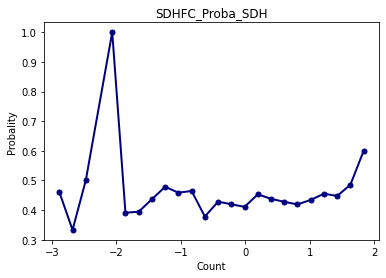

In [ ]:
ax = SDHFC_Proba_SDH.plot(lw=2, colormap='jet', marker='.', markersize=10, title='SDHFC_Proba_SDH')
ax.set_xlabel("Count")
ax.set_ylabel("Probability")
plt.show()

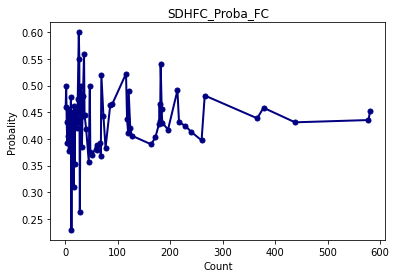

In [ ]:
ax = SDHFC_Proba_FC.plot(lw=2, colormap='jet', marker='.', markersize=10, title='SDHFC_Proba_FC')
ax.set_xlabel("Count")
ax.set_ylabel("Probability")
plt.show()

In [ ]:
# your code here
X_train_SDHSAH = x_train2.copy()
for i in x_train2.columns :
  if i != 'SCHED_DEP_HOUR' and i != 'SCHED_ARR_HOUR':
    X_train_SDHSAH[i] = x_train2[i].median()
y_train_SDHSAH = NN_model.predict(X_train_SDHSAH)
y_SDHSAH_bool=pd.DataFrame((y_train_SDHSAH>0.5).astype(int),columns=['probability'])
df_SDHSAH = pd.concat([x_train2['SCHED_DEP_HOUR'],df['SCHED_ARR_HOUR'],y_SDHSAH_bool],axis=1)
SDHFC_Proba_SDH = df_SDHSAH.groupby(['SCHED_DEP_HOUR']).mean().probability
SDHFC_Proba_SAH = df_SDHSAH.groupby(['SCHED_ARR_HOUR']).mean().probability

In [ ]:
SDHFC_Proba_SDH

SCHED_DEP_HOUR
-2.885553    0.538462
-2.680294    0.333333
-2.475035    0.500000
-2.064517    1.000000
-1.859257    0.489130
-1.653998    0.557333
-1.448739    0.563050
-1.243480    0.590909
-1.038221    0.544304
-0.832962    0.575385
-0.627703    0.507886
-0.422444    0.577143
-0.217185    0.520000
-0.011926    0.583562
 0.193334    0.584383
 0.398593    0.573034
 0.603852    0.570076
 0.809111    0.558282
 1.014370    0.567404
 1.219629    0.591549
 1.424888    0.572391
 1.630147    0.610169
 1.835406    0.750000
Name: probability, dtype: float64

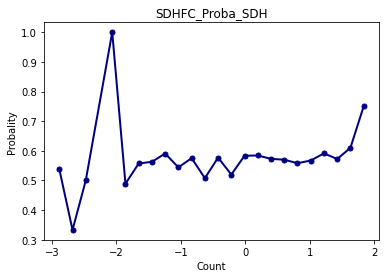

In [ ]:
ax = SDHFC_Proba_SDH.plot(lw=2, colormap='jet', marker='.', markersize=10, title='SDHFC_Proba_SDH')
ax.set_xlabel("Count")
ax.set_ylabel("Probability")
plt.show()


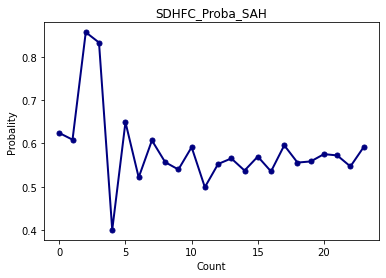

In [ ]:
ax = SDHFC_Proba_SAH.plot(lw=2, colormap='jet', marker='.', markersize=10, title='SDHFC_Proba_SAH')
ax.set_xlabel("Count")
ax.set_ylabel("Probability")
plt.show()


In [ ]:
# your code here
X_train_SDHD = x_train2.copy()
for i in x_train2.columns :
  if i != 'SCHED_DEP_HOUR' and i != 'DISTANCE':
    X_train_SDHD[i] = x_train2[i].median()
y_train_SDHD = NN_model.predict(X_train_SDHD)
y_SDHD_bool=pd.DataFrame((y_train_SDHD>0.5).astype(int),columns=['probability'])
df_SDHD = pd.concat([x_train2['SCHED_DEP_HOUR'],df['DISTANCE'],y_SDHSAH_bool],axis=1)
SDHFC_Proba_SDH = df_SDHD.groupby(['SCHED_DEP_HOUR']).mean().probability
SDHFC_Proba_D = df_SDHD.groupby(['DISTANCE']).mean().probability


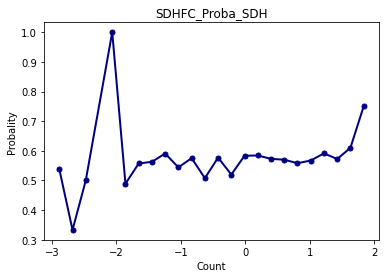

In [ ]:
ax = SDHFC_Proba_SDH.plot(lw=2, colormap='jet', marker='.', markersize=10, title='SDHFC_Proba_SDH')
ax.set_xlabel("Count")
ax.set_ylabel("Probability")
plt.show()

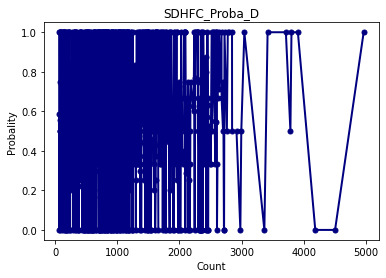

In [ ]:
ax = SDHFC_Proba_D.plot(lw=2, colormap='jet', marker='.', markersize=10, title='SDHFC_Proba_D')
ax.set_xlabel("Count")
ax.set_ylabel("Probability")
plt.show()

PREDICTONS (Neural Network) 

In [ ]:
y_pred = (NN_model.predict(x_train)> 0.5).astype('int32')
y_pred
#y_hat_NN_new= pd.DataFrame(data = y_pred,columns=['Predicted'])
#x_plot=pd.DataFrame(data=X_proba)

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
y_hat_NN_new['Predicted'].unique()

array([1], dtype=int32)

In [ ]:
y_hat_NN['Predicted'].shape

(8000,)

In [ ]:
x_plot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809
0,-0.889620,-1.036385,-1.282984,0.809111,0.665012,-0.455786,1.087153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.982376,-0.929684,1.705286,-1.859257,-1.600530,-0.832941,1.595691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.205233,0.297373,-0.984157,-0.217185,0.098627,0.908627,-0.438462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.036596,0.110647,1.705286,1.014370,1.042603,-0.128549,-0.438462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.347991,-0.316155,1.107632,-1.653998,-1.411735,-1.115807,0.578615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


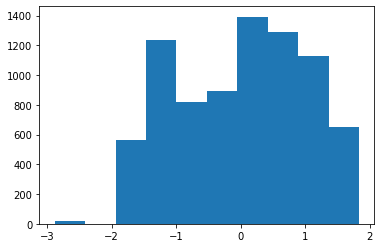

In [ ]:
plt.hist(x=x_plot[3].values)
plt.show()

**1.4.2**

In [ ]:
# The Second Part

In [ ]:
result3=final_result
result3.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2586,342.0,9,7,15,240,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1235,185.0,5,6,11,366,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,76.0,4,17,18,172,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,862,148.0,7,19,21,260,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,71.0,3,20,21,266,2


In [ ]:
#FLIGHT_COUNT EXCLUDED and SCHED_DEP_HOUR
col_num = ['SCHEDULED_TIME','DISTANCE']

In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

In [ ]:
for i in col_non_num:
  result3[i]=result3[i].mode()
  print(result3[i].mode())

0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64


In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

result3['origin_ASE']=0
result3['origin_ONT']=0
result3['origin_LFT']=0
result3['origin_DEN']=0
result3['dest_LAW']=0
result3['dest_ONT']=0

In [ ]:
result3['SCHEDULED_TIME']=list_st_mean
result3['DISTANCE']=list_dt_mean

In [ ]:
result3.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,240,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,366,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,172,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,260,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,266,2


In [ ]:
X_proba_2 = result3.drop('DELAY_OR_NOT',axis=1)
X_proba_2.head()

,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,origin_11612,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,240,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,366,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,172,7
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,260,7
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,266,2


PREDICTIONS 2

In [ ]:
w2=logreg.predict_proba(X_proba_2)

In [ ]:
print(w2)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


**1.4.3**

In [ ]:
result4=final_result
result4.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,240,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,366,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,172,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,260,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,266,2


In [ ]:
col_num = ['SCHEDULED_TIME','FLIGHT_COUNT','DISTANCE']

In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

In [ ]:
for i in col_non_num:
  result4[i]=result4[i].mode()
  print(result4[i].mode())

0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64


In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

result4['origin_ASE']=0
result4['origin_ONT']=0
result4['origin_LFT']=0
result4['origin_DEN']=0
result4['dest_LAW']=0
result4['dest_ONT']=0

In [ ]:
result4['SCHEDULED_TIME']=list_st_mean
result4['DISTANCE']=list_dt_mean
result4['FLIGHT_COUNT']=list_fc_mean

In [ ]:
result4.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,202.177,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,202.177,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,202.177,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,202.177,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,202.177,2


In [ ]:
X_proba_3 = result4.drop('DELAY_OR_NOT',axis=1)
X_proba_3.head()

,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,origin_11612,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,202.177,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,202.177,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,202.177,7
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,202.177,7
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,202.177,2


PREDICTIONS 3

In [ ]:
w3=logreg.predict_proba(X_proba_3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(w3)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


**1.4.4**

In [ ]:
result5=final_result
result5.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,202.177,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,202.177,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,202.177,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,202.177,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,202.177,2


In [ ]:
#Excluded DISTANCE
col_num = ['SCHEDULED_TIME','FLIGHT_COUNT']

In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

In [ ]:
for i in col_non_num:
  result5[i]=result5[i].mode()
  print(result5[i].mode())

0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64
0    0.0
dtype: float64


In [ ]:
col_non_num=['origin_ASE',
 'origin_ONT',
 'dest_LAW',
 'dest_ONT',
 'origin_LFT','origin_DEN']

result5['origin_ASE']=0
result5['origin_ONT']=0
result5['origin_LFT']=0
result5['origin_DEN']=0
result5['dest_LAW']=0
result5['dest_ONT']=0

In [ ]:
result5['SCHEDULED_TIME']=list_st_mean
result5['DISTANCE']=list_dt_mean
result5['FLIGHT_COUNT']=list_fc_mean

In [ ]:
result5.head()

,DELAY_OR_NOT,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,202.177,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,202.177,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,202.177,7
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,202.177,7
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,202.177,2


In [ ]:
X_proba_4 = result5.drop('DELAY_OR_NOT',axis=1)
X_proba_4.head()

,origin_10140,origin_10208,origin_10257,origin_10279,origin_10372,origin_10397,origin_10423,origin_10529,origin_10620,origin_10693,origin_10713,origin_10721,origin_10747,origin_10779,origin_10781,origin_10792,origin_10800,origin_10821,origin_10868,origin_10874,origin_10990,origin_10994,origin_11042,origin_11049,origin_11057,origin_11066,origin_11109,origin_11193,origin_11259,origin_11267,origin_11278,origin_11292,origin_11298,origin_11315,origin_11413,origin_11423,origin_11433,origin_11540,origin_11603,origin_11612,...,dest_SFO,dest_SGF,dest_SGU,dest_SHV,dest_SIT,dest_SJC,dest_SJT,dest_SJU,dest_SLC,dest_SMF,dest_SMX,dest_SNA,dest_SPI,dest_SPS,dest_SRQ,dest_STL,dest_STT,dest_SUN,dest_SYR,dest_TLH,dest_TPA,dest_TRI,dest_TTN,dest_TUL,dest_TUS,dest_TVC,dest_TYR,dest_TYS,dest_VLD,dest_VPS,dest_XNA,dest_YAK,dest_YUM,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,9,7,15,202.177,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,5,6,11,202.177,4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,4,17,18,202.177,7
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,7,19,21,202.177,7
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,830.094,142.7041,3,20,21,202.177,2


PREDICTIONS 4

In [ ]:
w4=logreg.predict_proba(X_proba_4)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print(w4)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


**INTERPRETATION:**

We have made the plots based on the count of the key features based on the permutation_importance along with the ones we were told to omit while plotting the graphs for **delay (predicted)** vs **SCHED_DEP_HOUR**.

The plots were sporadic and one of the important features was also not  replaced with the mean

<div class='exercise-r'>

**1.5**

</div>

In [ ]:
list_of_pred=[]

In [ ]:
result.head()

In [ ]:
def bootstrap(df):
    selectionIndex = np.random.randint(0, df.shape[0], size = df.shape[0])
    new_df = df.iloc[selectionIndex]
    return new_df

In [ ]:
for i in range(50):

    # Create bootstrapped version of the data using the bootstrap function
    # Set frac=1 and replace=True to get a bootstrap
    df_new = bootstrap(result)

    X_new = df_new.drop(["DELAY_OR_NOT"],axis = 1).values
    y_new = df_new['DELAY_OR_NOT']
    #x_boot_train,x_boot_test,y_boot_train,y_boot_test=train_test_split(X_new,y_new,test_size=0.2,random_state=420)
    NN_model_Boot = models.Sequential(name='Unregularized')

    # Add 2 hidden layers with 15 neurons each
    NN_model_Boot.add(layers.Input(shape = len(X[0]), name = 'input'))
    NN_model_Boot.add(layers.Dense(15,  activation='relu'))
    NN_model_Boot.add(layers.Dense(15,  activation='relu'))
    NN_model_Boot.add(layers.Dense(1,  activation='sigmoid'))

    NN_model_Boot.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    history_Boot = NN_model_Boot.fit(X_new,y_new,epochs=5,batch_size=10,verbose=1)
    
    # Predict on the bootstrapped data
    y_pred_boot = NN_model_Boot.predict(x_test) 

    list_of_pred.append(y_pred_boot)


In [ ]:
list_of_pred

In [ ]:
len(list_of_pred[0])

2000

In [ ]:
list_rand=np.random.randint(0,100,8)
list_rand

array([74, 85, 78, 51, 73, 39, 94, 47])

In [ ]:
pop=[]
for i in list_rand:
  z=list_of_pred[i]
  pop.append(z)

In [ ]:
len(pop)

8

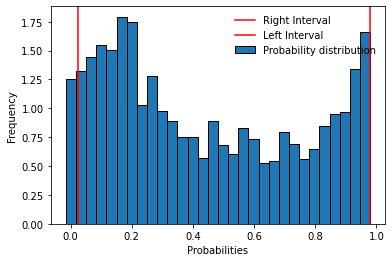

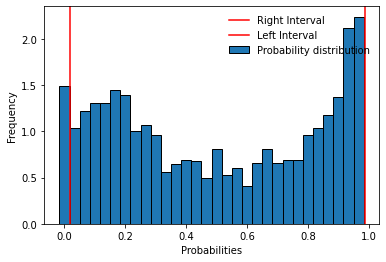

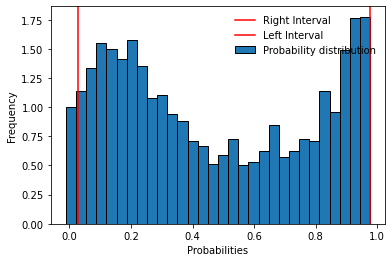

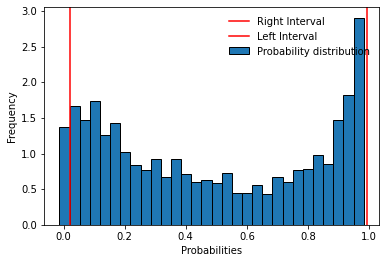

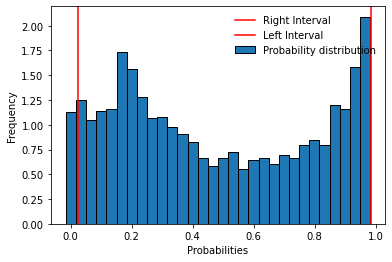

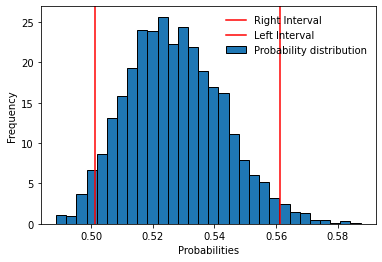

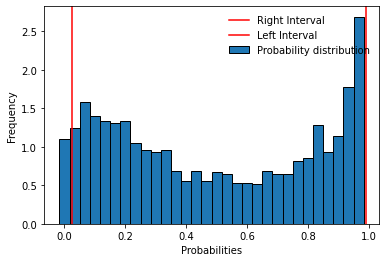

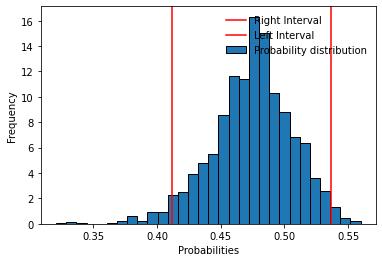

In [ ]:
for i in pop:
  i.sort()
  # Find the 95% confidence interval using np.percentile function 
  # at 2.5% and 97.5%
  list_of_pred_CI = (np.percentile(i,2.5),np.percentile(i, 97.5))
  plot_simulation(i,list_of_pred_CI)

In [ ]:
def plot_simulation(simulation,confidence):
    plt.hist(simulation, bins = 30, label = 'Probability distribution', align = 'left', density = True,edgecolor='k')
    plt.axvline(confidence[1], 0, 1, color = 'r', label = 'Right Interval')
    plt.axvline(confidence[0], 0, 1, color = 'red', label = 'Left Interval')
    plt.xlabel('Probabilities')
    plt.ylabel('Frequency')
    plt.legend(frameon = False, loc = 'upper right')
    plt.show();

**INTERPRETATION:**

After fitting the NN_model on the Bootstrapped Dataset, we took 8 random test observations and the probabilit distribution for the those samples was found to be in range **[0.2,0.5]** for some and rest were a little more spread out and ranged from **[0,1)**

<div class='exercise-r'>

**1.6**

</div>

In [ ]:
#calculating the ppr values
ppr=np.sum(np.where(y_pred_boot>0.5,1,0),axis=1)/50
y_bag=np.where(ppr>0.5,1,0)
print("Accuracy Score : ",accuracy_score(y_test,y_bag))

Accuracy Score :  0.5105


In [ ]:
num_points=25
ppr_thresh= np.linspace(0,0.5,num=num_points,endpoint=True)
abstain_acc= np.zeros(num_points)
num_of_test_obs=np.zeros(num_points)


for i in range(len(ppr_thresh)):
  abs_index = ( ppr<=ppr_thresh[i]) | (ppr>=1-ppr_thresh[i]) 
  y_test_abs=y_test[abs_index]

  y_test_pred_abs=np.where(ppr[abs_index]>0.5,1,0)
  abstain_acc[i]= accuracy_score(y_test_abs,y_test_pred_abs)
  num_of_test_obs[i]=np.shape(y_test_abs)[0]

(0.5, 0.0)

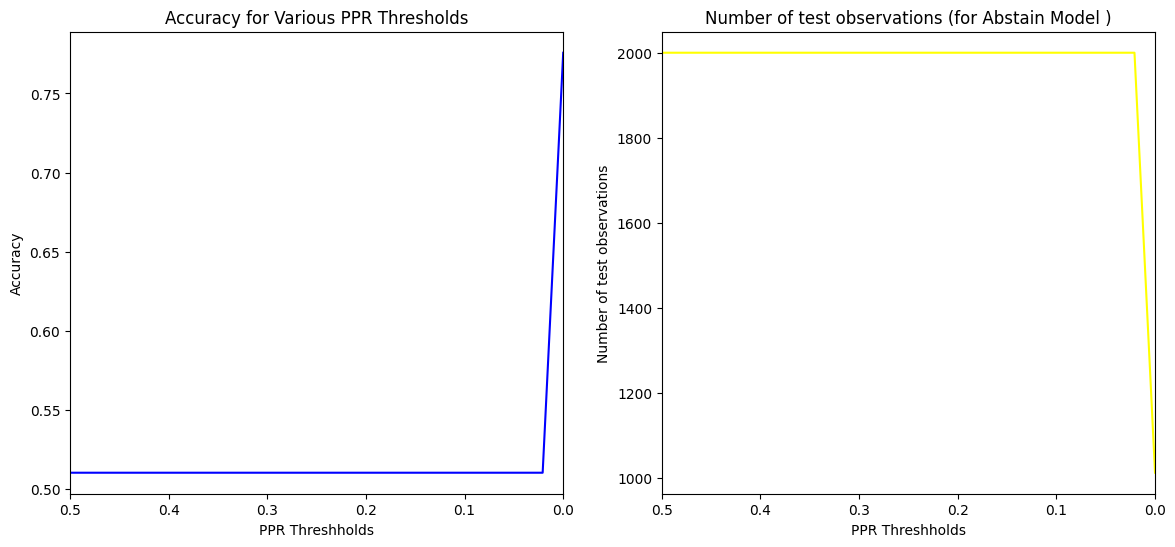

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(ppr_thresh,abstain_acc,color='blue')
ax[0].set_xlabel('PPR Threshholds')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy for Various PPR Thresholds')
ax[0].set_xlim(0.5,0)


ax[1].plot(ppr_thresh,num_of_test_obs,color='yellow')
ax[1].set_xlabel('PPR Threshholds')
ax[1].set_ylabel('Number of test observations')
ax[1].set_title('Number of test observations (for Abstain Model )')
ax[1].set_xlim(0.5,0)

**INTERPRETATION:**

The Accuracy decreases as we approach the PPR value of 0.5 and then goes all the way up as soon as the threshold val is decreased

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h1>PART 2.1 [30 pts]: Kannada MNIST Kaggle competition using ANNs </h1>


<a id="part2.1intro"></a>
<h2> Problem Statement </h2>

ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2.1about"></a>

<h3> The Kannada MNIST Dataset </h3>

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media" style="float:right">

For this problem, we will be working with a modified version of [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf) , which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only use the digits labeled `0` and `1` owing to the similarity of the two symbols, and we want to use a total of 1200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

<h3> Downloading the Data Files </h3>

Please download all files from Kaggle [using this link](https://www.kaggle.com/c/c2ai2hw1/data).

Here's a brief description of the available files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.

Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada language.  

- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2000 samples. 

Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept.

<a id="part2.1kaggle"></a>

<h3> AI2-C2 Homework Kaggle Competition </h3>

You need to create an account on Kaggle and join the competition via this [link](https://www.kaggle.com/t/d20c82e91e1a43b2967c6127171d1661). **This is a limited participation competition. Please DO NOT share this link.**

For more information on the rules governing this Kaggle competition, **please [see question 2.1.3 below](#part2_3).**

</div>

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h2>PART 2.1 Questions</h2>

**2.1.1 [5 points]** **Get the data:**

- Download data from the competition page.
- We will utilize `kmnist_test.csv` in question 2.1.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1.

**2.1.2 [10 points]** **Overfit an ANN:** 

Build a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: no more than 2,000
- Batch size: 128
- Validation size: 0.3

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="part2_3"></a>

**2.1.3 [15 points]** **Regularize overfit network:**

Create an ANN that doesn't overfit and compete on Kaggle.

**DON'TS**

**Don't change the architecture**. In other words, keep the number of layers, number of nodes, activation function,  loss function and output unit the same. **No CNNs/RNNs/enhancements allowed for the competition.**

    
**NOTE**: We strongly discourage you to use a different training set than the one provided to you (Data augmentation is allowed). If the test set accuracy of your model in this notebook is significantly different than your kaggle submission score, you will receive zero credit for this segment of the homework.

    
**DOS**

You can change the number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize (e.g., dropout, L2 norm, etc.). You can also do data augmentation. 


- **2.1.3.1** Display your model summary and your training and validation accuracy and loss.


- **2.1.3.2** Print the difference between the training and validation accuracies and the difference between the training and validation losses for the final trained epoch used by your model.


- **2.1.3.3** Plot the training accuracy and validation accuracy as a function of epochs.


- **2.1.3.4** Generate your test set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file to this Kaggle Competition for leaderboard scoring.


- **2.1.3.5** **Specify your Kaggle name that you have used on the leaderboard**. *We can't give you credit without this.*


    
**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on kaggle only displays your performance on 50% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the FULL test set.
    
Only the **top 5** competitors (as ranked on the hidden private leaderboard) will be eligible for full credit on question 2.1.3 (out of **15 points**). Remaining competitors will be scored out of **10 points** only for 2.1.3.


**ADDITIONAL RULES:**

- Multiple Kaggle submissions are permitted, **just note** that you will need to choose, on Kaggle, which submission shall be used for final scoring.


- The version of your final notebook submitted on edStem **must contain the same model** used to generate to your chosen Kaggle submission.


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, please only use the KMNIST training data downloaded via the link above for training your model.**


- **Do not** create multiple accounts on Kaggle.

</div>

<a id="part2.1solutions"></a>

## PART 2.1 Solutions




<div class='exercise-r'>

**2.1.1** 
    
</div>

In [ ]:
# your code here 
# your code here 
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# your code here 
train = pd.read_csv('kmnist_train.csv')
test = pd.read_csv('kmnist_test.csv')

In [ ]:
train.head()

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,pixel 11,pixel 12,pixel 13,pixel 14,pixel 15,pixel 16,pixel 17,pixel 18,pixel 19,pixel 20,pixel 21,pixel 22,pixel 23,pixel 24,pixel 25,pixel 26,pixel 27,pixel 28,pixel 29,pixel 30,pixel 31,pixel 32,pixel 33,pixel 34,pixel 35,pixel 36,pixel 37,pixel 38,pixel 39,pixel 40,...,pixel 746,pixel 747,pixel 748,pixel 749,pixel 750,pixel 751,pixel 752,pixel 753,pixel 754,pixel 755,pixel 756,pixel 757,pixel 758,pixel 759,pixel 760,pixel 761,pixel 762,pixel 763,pixel 764,pixel 765,pixel 766,pixel 767,pixel 768,pixel 769,pixel 770,pixel 771,pixel 772,pixel 773,pixel 774,pixel 775,pixel 776,pixel 777,pixel 778,pixel 779,pixel 780,pixel 781,pixel 782,pixel 783,pixel 784,output
0,56.514675,24.749116,15.420758,68.951633,13.760997,13.309949,68.951633,68.951633,13.309949,68.951633,13.309949,13.309949,68.951633,13.309949,19.217384,66.610157,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,29.956843,55.571588,13.309949,13.309949,68.951633,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,34.894341,13.309949,51.719255,...,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,68.951633,68.951633,68.951633,51.979121,13.309949,13.309949,13.309949,68.951633,13.309949,13.309949,13.309949,68.951633,13.309949,67.057540,49.442897,68.951633,13.309949,13.309949,13.309949,13.309949,13.309949,13.309949,15.812025,13.309949,31.413656,13.309949,23.733776,13.309949,13.309949,13.309949,68.951633,32.487911,13.309949,1
1,13.122449,13.122449,13.122449,13.122449,13.122449,13.122449,43.090392,15.339362,13.122449,13.122449,58.698975,28.332857,47.774450,13.122449,44.661637,32.080146,13.122449,13.122449,43.629253,13.122449,13.122449,13.122449,39.988326,13.122449,13.122449,58.698975,13.122449,13.122449,13.122449,13.122449,16.599022,15.200110,13.122449,13.122449,58.698975,13.122449,13.122449,31.271726,13.122449,13.122449,...,13.122449,13.122449,13.122449,13.122449,13.122449,22.768886,35.558185,13.122449,24.306962,13.122449,13.122449,13.122449,58.698975,58.698975,13.122449,30.134518,13.122449,13.122449,58.698975,13.122449,13.122449,13.122449,13.122449,13.122449,13.122449,22.674487,58.698975,13.122449,13.122449,13.122449,13.122449,13.122449,13.122449,24.566333,13.122449,13.122449,13.122449,13.409452,13.122449,1
2,56.228990,38.733386,43.356041,30.350765,30.350765,101.791573,30.350765,30.350765,101.791573,56.951487,30.350765,30.350765,30.350765,51.795550,30.350765,30.350765,55.629080,30.350765,30.350765,61.090311,101.791573,101.791573,30.350765,30.350765,30.350765,30.350765,77.776984,30.350765,60.708022,30.350765,30.350765,30.350765,36.268707,34.541854,30.350765,30.350765,101.791573,30.350765,45.196318,64.105283,...,30.350765,101.470986,65.060079,60.536067,30.350765,30.350765,70.228380,30.350765,30.350765,91.701879,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,64.267736,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,34.596812,30.350765,42.318026,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,30.350765,50.652863,101.791573,30.350765,0
3,67.072705,33.257721,51.330661,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,44.554188,17.868622,39.534184,32.396238,45.220379,25.924024,17.868622,17.868622,64.785868,73.167338,17.868622,35.528265,17.868622,73.689417,17.868622,27.616360,38.240617,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,73.689417,42.130311,73.689417,17.868622,52.849719,37.838234,...,17.868622,17.868622,17.868622,17.868622,36.892379,59.445016,40.789161,17.868622,64.548866,17.868622,17.868622,42.817874,17.868622,43.985603,73.689417,50.401435,17.868622,63.357831,35.806691,67.817666,17.868622,17.868622,55.725766,50.271325,17.868622,73.689417,17.868622,54.406792,26.072700,54.301599,73.689417,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,17.868622,0
4,17.867347,17.867347,17.867347,28.235052,17.867

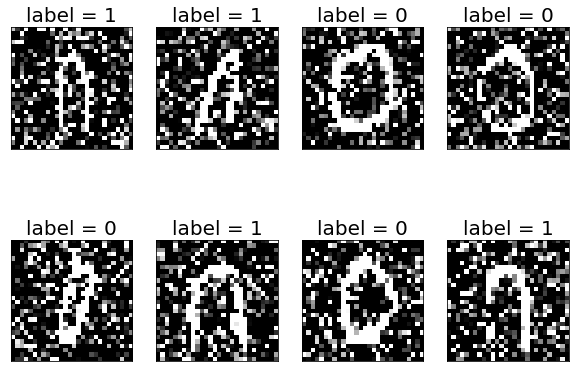

In [ ]:
plt.figure(figsize=(10, 15))
for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(k_train.iloc[i, :-1].values.reshape(28, 28), cmap='gray')
    plt.title(f"label = {k_train.iloc[i, -1]}", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

<div class='exercise-r'>

**2.1.2**
    
</div>

In [ ]:
x_train = train.drop(columns='output')
y_train = train['output']

In [ ]:
x_train.shape

(1200, 784)

In [ ]:
overfit_model = models.Sequential()
overfit_model.add(layers.Dense(100, input_shape=(784,), activation='relu', name='hidden_1'))
overfit_model.add(layers.Dense(100, activation='relu', name='hidden_2'))
overfit_model.add(layers.Dense(100, activation='relu', name='hidden_3'))
overfit_model.add(layers.Dense(1, activation='sigmoid', name='output'))

overfit_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 100)               78500     
                                                                 
 hidden_2 (Dense)            (None, 100)               10100     
                                                                 
 hidden_3 (Dense)            (None, 100)               10100     
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
overfit_model.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

history_1 = overfit_model.fit(x_train, y_train, validation_split=0.3, batch_size=128, verbose=1, epochs=500)

Epoch 1/500
7/7 [==============================] - 1s 53ms/step - loss: 5.7944 - accuracy: 0.5321 - val_loss: 4.0423 - val_accuracy: 0.5000
Epoch 2/500
7/7 [==============================] - 0s 11ms/step - loss: 2.1569 - accuracy: 0.5893 - val_loss: 1.2967 - val_accuracy: 0.6194
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 1.0043 - accuracy: 0.6560 - val_loss: 0.9346 - val_accuracy: 0.6611
Epoch 4/500
7/7 [==============================] - 0s 12ms/step - loss: 0.6795 - accuracy: 0.7298 - val_loss: 0.8092 - val_accuracy: 0.6972
Epoch 5/500
7/7 [==============================] - 0s 11ms/step - loss: 0.6092 - accuracy: 0.7619 - val_loss: 0.9160 - val_accuracy: 0.6917
Epoch 6/500
7/7 [==============================] - 0s 11ms/step - loss: 0.4985 - accuracy: 0.8012 - val_loss: 0.9423 - val_accuracy: 0.6944
Epoch 7/500
7/7 [==============================] - 0s 10ms/step - loss: 0.4340 - accuracy: 0.8214 - val_loss: 0.7295 - val_accuracy: 0.7444
Epoch 8/500
7/7 [===

Training Accuracy:1.0 
Validation Accuracy:0.9194444417953491


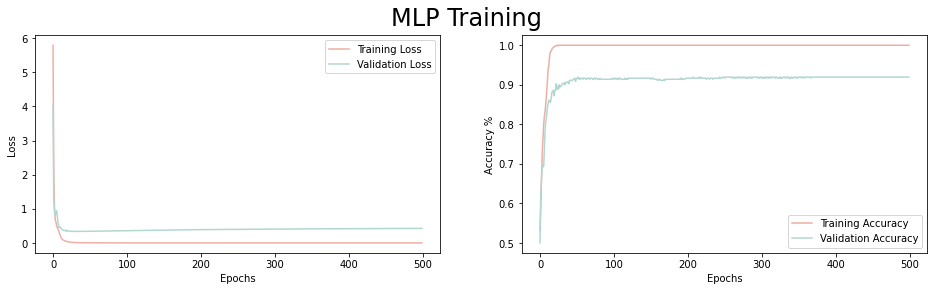

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history_1.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history_1.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history_1.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history_1.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('MLP Training', fontsize = 24)

print('Training Accuracy:{} \nValidation Accuracy:{}'.format(history_1.history['accuracy'][-1], history_1.history['val_accuracy'][-1]))

**INTERPRETATION**

Overfitting occurs when our model becomes really good at being able to classify or predict on data that was included in the training set, but is not as good at classifying data that it wasn't trained on. So essentially, the model has overfit the data in the training set.
Here we can clearly see, our model has 100% accuracy on training set, but has 89% accuracy on validation set, it implies that this neural network is overfitting.

**2.1.3** 

**2.1.3.1**

In [ ]:
# your code here
# defining some helper functions

def progressbar(n_step, n_total):
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        
        status,
    )
    
def preprocess_img(df, label=None):
    new_data = df.copy()
    for i in range(new_data.shape[0]):
        progressbar(i, new_data.shape[0])
        img = df.iloc[i].values
        img[img < img.max()] = 0
        img[img > 0] = 255
        new_img = img.reshape(28, 28)
        new_img[:4, :] = 0
        new_img[27:, :] = 0
        new_img[:, :6] = 0
        new_img[:, 22:] = 0
        new_data.iloc[i] = pd.DataFrame([new_img.reshape(-1,)]).values
    if label is not None:
        return pd.concat([new_data, label], axis=1)
    return new_data

# this function accepts a dataframe and label and returns horizontal flipped version of all data
def hflip(df, label):
    new_data = df.copy()
    for i in range(new_data.shape[0]):
        progressbar(i, new_data.shape[0])
        img = df.iloc[i].values.reshape(28, 28)
        new_img = np.fliplr(img)
        new_data.iloc[i] = pd.DataFrame([new_img.reshape(-1,)]).values
    return pd.concat([new_data, label], axis=1)

In [ ]:
# preprocess image
cleaned_data = preprocess_img(train.iloc[:, :-1], train.iloc[:, -1])

In [ ]:
# create horizontally flipped version of data
hf_data = hflip(cleaned_data.iloc[:, :-1], cleaned_data.iloc[:, -1])

In [ ]:
# augment new data
aug_data = pd.concat([cleaned_data, hf_data])
aug_data = aug_data.sample(frac=1)
aug_data.shape

(2400, 785)

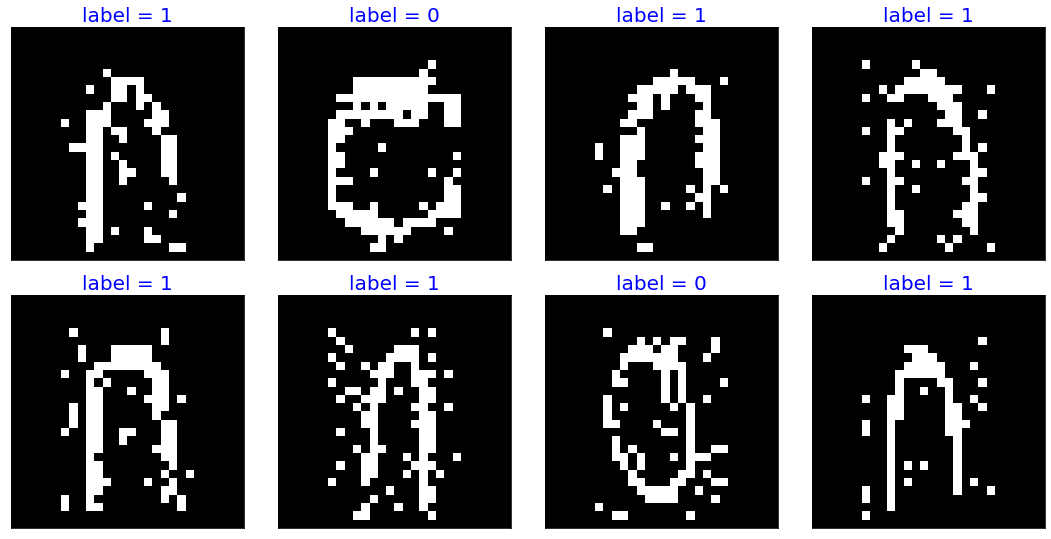

In [ ]:
plt.figure(figsize=(15, 15))
plt.style.use('default')
for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(aug_data.iloc[i, :-1].values.reshape(28, 28), cmap='gray')
    plt.title(f"label = {int(aug_data.iloc[i, -1])}", fontsize=20, c='blue')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# Separate predictor and response variables
X = aug_data.drop('output', axis=1)
y = aug_data.output

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def build_model(input_shape):
    model = keras.Sequential()
    l2 = keras.regularizers.l2(0.01)
    l1 = keras.regularizers.l1(0.01)
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    # add dropout layer
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
    
    return model

In [ ]:
# create a model
regularized_model = build_model(X.shape[1:])
# create early stopping callback
es_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# normalize all data
X_n = X / 255
# fit the model
history_2 = regularized_model.fit(X_n, y, epochs=2000, batch_size=64, validation_split=0.3, callbacks=[es_cb])

Epoch 1/2000
27/27 [==============================] - 1s 19ms/step - loss: 3.6131 - accuracy: 0.6821 - val_loss: 2.6581 - val_accuracy: 0.9083
Epoch 2/2000
27/27 [==============================] - 0s 8ms/step - loss: 2.2399 - accuracy: 0.8482 - val_loss: 1.6908 - val_accuracy: 0.9181
Epoch 3/2000
27/27 [==============================] - 0s 8ms/step - loss: 1.5259 - accuracy: 0.8810 - val_loss: 1.1709 - val_accuracy: 0.9528
Epoch 4/2000
27/27 [==============================] - 0s 9ms/step - loss: 1.1292 - accuracy: 0.9060 - val_loss: 0.8813 - val_accuracy: 0.9625
Epoch 5/2000
27/27 [==============================] - 0s 10ms/step - loss: 0.8874 - accuracy: 0.9054 - val_loss: 0.7022 - val_accuracy: 0.9542
Epoch 6/2000
27/27 [==============================] - 0s 8ms/step - loss: 0.7325 - accuracy: 0.9036 - val_loss: 0.5770 - val_accuracy: 0.9500
Epoch 7/2000
27/27 [==============================] - 0s 8ms/step - loss: 0.6208 - accuracy: 0.9095 - val_loss: 0.4778 - val_accuracy: 0.9597
Epoc

In [ ]:
# your code here
regularized_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 784)               0         
                                                                 
 dense_471 (Dense)           (None, 100)               78500     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_472 (Dense)           (None, 100)               10100     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_473 (Dense)           (None, 100)               10100     
                                                                 
 dropout_15 (Dropout)        (None, 100)              

**2.1.3.2**

In [ ]:
# your code here
# Print Last Epoch Accuracy and Loss
train_acc = history_2.history['accuracy'][-1]
test_acc = history_2.history['val_accuracy'][-1]
train_loss = history_2.history['loss'][-1]
test_loss = history_2.history['val_loss'][-1]

print("Final train accuracy: {:.2f}%".format(train_acc*100))
print("Final test accuracy: {:.2f}%".format(test_acc*100))
print("Final train loss: {:.4f}".format(train_loss))
print("Final test loss: {:.4f}".format(test_loss))

Final train accuracy: 94.17%
Final test accuracy: 97.50%
Final train loss: 0.2426
Final test loss: 0.1931


2.1.3.3

Training Accuracy:0.9416666626930237 
Validation Accuracy:0.9750000238418579


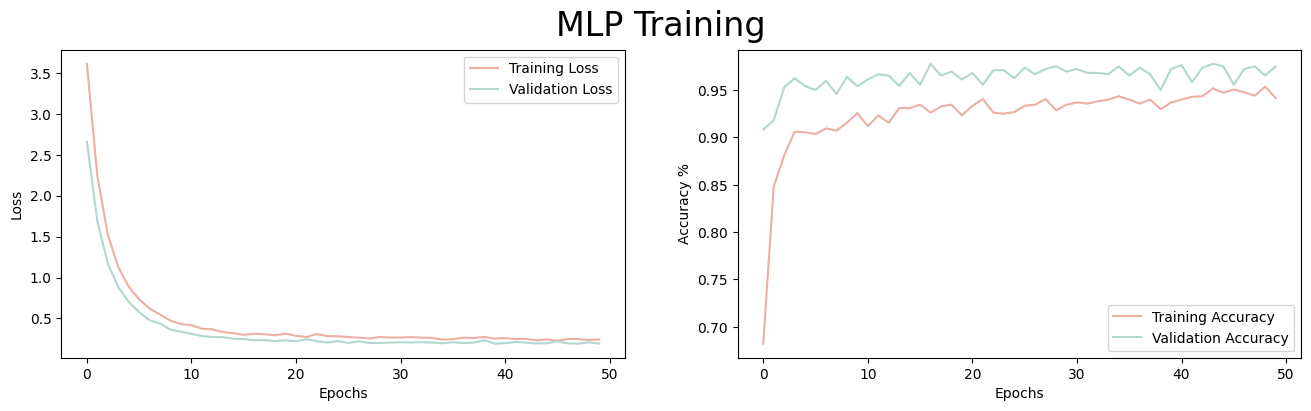

In [ ]:
# your code here
# your code here
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history_2.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history_2.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history_2.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history_2.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('MLP Training', fontsize = 24)

print('Training Accuracy:{} \nValidation Accuracy:{}'.format(history_2.history['accuracy'][-1], history_2.history['val_accuracy'][-1]))

In [ ]:
# your code here
# load test data
test = pd.read_csv('kmnist_test.csv')
# preprocess test data
preprocessed_test = preprocess_img(test)
test = preprocessed_test.copy()
test_n = test/255
# predict on test data
preds = (regularized_model.predict(test_n) > 0.5).astype("int32")

In [ ]:
submission=pd.read_csv('sample_submission.csv')

In [ ]:
submission['category'] = preds

In [ ]:
submission.to_csv('check1.csv', index=False)

**YOUR KAGGLE LEADERBOARD NAME:**

**Name** : *NHK?*

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h1>PART 2.2 [30points]: KMNIST Classification using CNNs</h1>

In this part of Homework, you will now contruct a CNN-based model in order to best classify the Kannada MNIST dataset.

**2.2.1 [5 points]** Examine the dataset and prepare the data by appropriately standardizing, reshaping and type-checking. 

**2.2.2 [20 points]** Construct a simple CNN model - with not more than 10 layers. Please ensure that you use the following layers/parameters in order to contruct the model -
1. Maxpooling
2. Dense layers
3. Regularization methods such as Adam, Drop out, Batch Normalization etc. 

**2.2.3 [5 points]** Perform error analysis on the predictions of your model and report classification accuracy. This should also include loss plots that allow for comparision of the model performance across the epochs. Conclusively, provide a detailed inference of why certain misclassifications would have taken place.



</div>

<a id="part2.2solutions"></a>

## PART 2.2 Solutions




**2.2.1**

In [ ]:
#your code here
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
IMG_SIZE = 28
N_CHANNELS = 1 # because gray scale images

In [ ]:
train_df = pd.read_csv('kmnist_train.csv')
pred_df = pd.read_csv('kmnist_test.csv')

In [ ]:
print (f'Training set: {train_df.shape}')
print (f'To be Predicted: {pred_df.shape}')

Training set: (1200, 785)
To be Predicted: (2000, 784)


In [ ]:
X_train = train_df.drop(['output'], axis = 1)
Y_train = train_df['output']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.05)

In [ ]:
X_train, X_test = X_train.apply(lambda x: x/255), X_test.apply(lambda x: x/255)

In [ ]:
Y_train, Y_test = pd.get_dummies(Y_train), pd.get_dummies(Y_test)

In [ ]:
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [ ]:
X_train.shape

(1140, 28, 28, 1)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# This will just calculate parameters required to augment the given data. This won't perform any augmentations
datagen.fit(X_train)

**2.2.2**

In [ ]:
#your code here
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.40))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.40))
model.add(Dense(2, activation = "softmax"))

In [ ]:
model.compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])

In [ ]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
batch_size=32
epochs = 45

In [ ]:
# Fit the model
history_3 = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                              epochs = 45, validation_data = (X_test,Y_test),
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

In [ ]:
preds = model.predict(pred_df.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS))

**2.2.3**

Training Accuracy:0.9846570491790771 
Validation Accuracy:0.9833333492279053


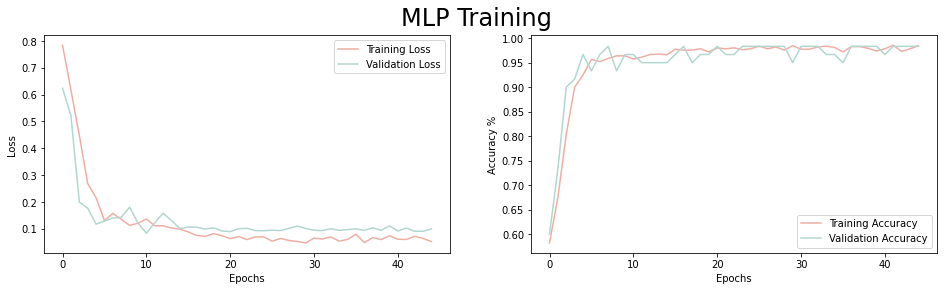

In [ ]:
# your code here
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history_3.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history_3.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history_3.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history_3.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('MLP Training', fontsize = 24)

print('Training Accuracy:{} \nValidation Accuracy:{}'.format(history_3.history['accuracy'][-1], history_3.history['val_accuracy'][-1]))

In [ ]:
# Print Last Epoch Accuracy and Loss
train_acc = history_3.history['accuracy'][-1]
test_acc = history_3.history['val_accuracy'][-1]
train_loss = history_3.history['loss'][-1]
test_loss = history_3.history['val_loss'][-1]

print("Final train accuracy: {:.2f}%".format(train_acc*100))
print("Final test accuracy: {:.2f}%".format(test_acc*100))
print("Final train loss: {:.4f}".format(train_loss))
print("Final test loss: {:.4f}".format(test_loss))

Final train accuracy: 98.47%
Final test accuracy: 98.33%
Final train loss: 0.0523
Final test loss: 0.0994


In [ ]:
cfm = confusion_matrix(np.argmax(Y_test.to_numpy(), axis=1), np.argmax(model.predict(X_test), axis=1))
cfm = pd.DataFrame(cfm,index=range(0,2),columns=range(0,2))
cfm

,0,1
0,34,1
1,0,25


**Error Analysis Inference:**

*Neural networks tend to have very steep transitions between classes, so examples can be near the boundary between two classes, and yet be dramatically misclassified. Adversarial examples take advantage of that by finding small modifications to an image from class a that cause it to be classified as class b.*